<a href="https://colab.research.google.com/github/veryHapppy/study_ai/blob/main/CV/FasterRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install cython

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import zipfile
import joblib

zip_path = '/content/drive/MyDrive/Colab Notebooks/[CV] coco/coco.zip'
extract_path = '/content/dataset'
with zipfile.ZipFile(zip_path, 'r') as z :
  z.extractall(extract_path)

Mounted at /content/drive


In [8]:
import os
import torch
from PIL import Image
from pycocotools.coco import COCO
from torch.utils.data import Dataset

class COCODataset(Dataset):
  def __init__(self, root, train, transform=None):
    super().__init__()
    directory = "train"if train else "val"
    annotations = os.path.join(root, "annotations", f"{directory}_annotations.json")

    self.coco = COCO(annotations)
    self.image_path = os.path.join(root, directory)
    self.transform = transform

    self.categories = self._get_categories()
    self.data = self._load_data()

  def _get_categories(self):
    categories = {0: "background"}
    for category in self.coco.cats.values():
      categories[category["id"]] = category["name"]
    return categories

  def _load_data(self):
    data = []
    for _id in self.coco.imgs:
      file_name = self.coco.loadImgs(_id)[0]["file_name"]
      image_path = os.path.join(self.image_path, file_name)
      image = Image.open(image_path).convert("RGB")

      boxes = []
      labels = []
      anns = self.coco.loadAnns(self.coco.getAnnIds(_id))
      for ann in anns:
        x,y,w,h = ann["bbox"]
        boxes.append([x,y,x+w,y+h])
        labels.append(ann["category_id"])

      target = {
          "image_id": torch.LongTensor([_id]),
          "boxes": torch.FloatTensor(boxes),
          "labels": torch.LongTensor(labels)
      }
      data.append([image, target])

    return data

  def __getitem__(self, index):
    image, target = self.data[index]
    if self.transform:
      image = self.transform(image)
    return image, target

  def __len__(self):
    return len(self.data)

In [9]:
from torchvision import transforms
from torch.utils.data import DataLoader

def collator(batch):
  return tuple(zip(*batch))

transform = transforms.Compose(
    [
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(dtype=torch.float)
    ]
)

train_dataset = COCODataset(extract_path, train=True, transform=transform)
test_dataset = COCODataset(extract_path, train=False, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=True, collate_fn=collator)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, drop_last=True, collate_fn=collator)

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [11]:
from torchvision import models
from torchvision import ops
from torchvision.models.detection import rpn
from torchvision.models.detection import FasterRCNN

backbone = models.vgg16(weights="VGG16_Weights.IMAGENET1K_V1").features
backbone.out_channels = 512

anchor_generator = rpn.AnchorGenerator(
    sizes=((32, 64, 128, 256, 512), ),
    aspect_ratios=((0.5, 1.0, 2.0),)
)
roi_pooler = ops.MultiScaleRoIAlign(
    featmap_names=["0"],
    output_size=(7, 7),
    sampling_ratio=2
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = FasterRCNN(
    backbone=backbone,
    num_classes=3,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
).to(device)

In [12]:
from torch import optim

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [13]:
for epoch in range(5):
  cost = 0.0
  for idx, (images, targets) in enumerate(train_dataloader):
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    loss_dict = model(images, targets)
    losses = sum(loss for loss in loss_dict.values())

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    cost += losses.item()

  lr_scheduler.step()
  cost = cost / len(train_dataloader)
  print(f"Epoch : {epoch+1:4d}, cost : {cost:.3f}")

Epoch :    1, cost : 0.451
Epoch :    2, cost : 0.302
Epoch :    3, cost : 0.278
Epoch :    4, cost : 0.268
Epoch :    5, cost : 0.256


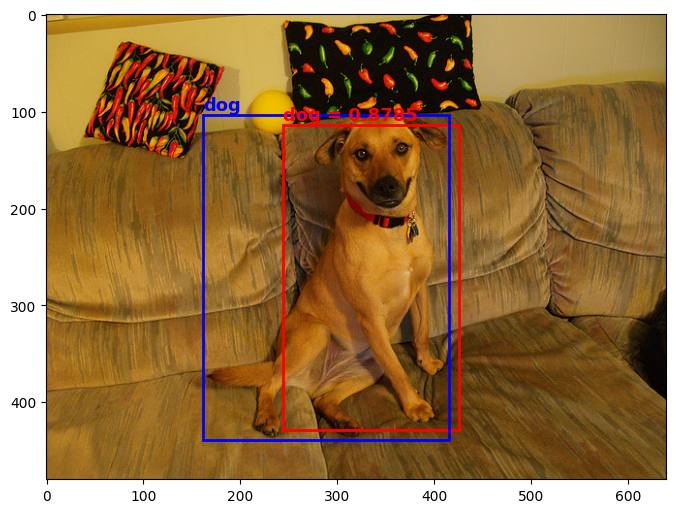

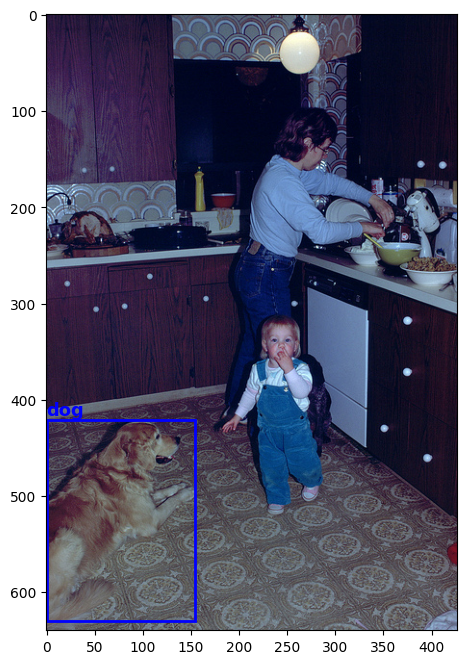

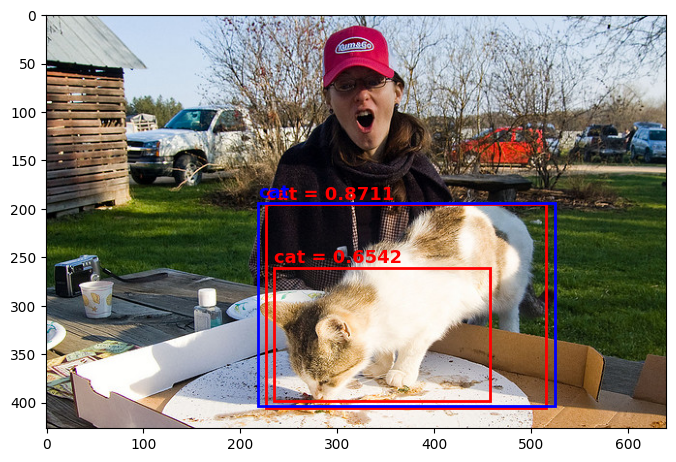

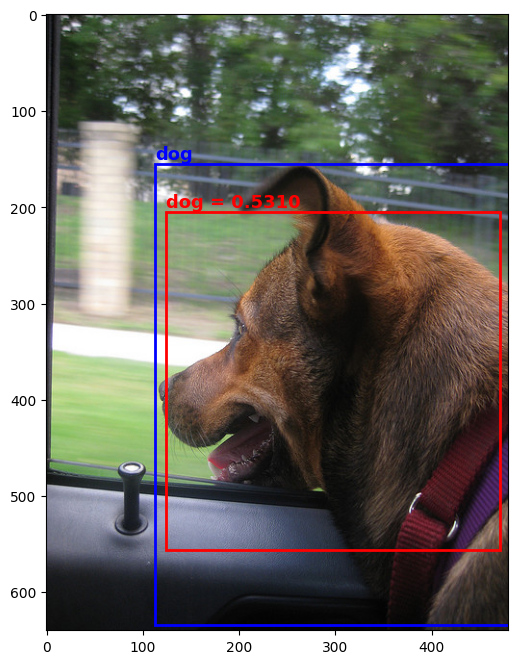

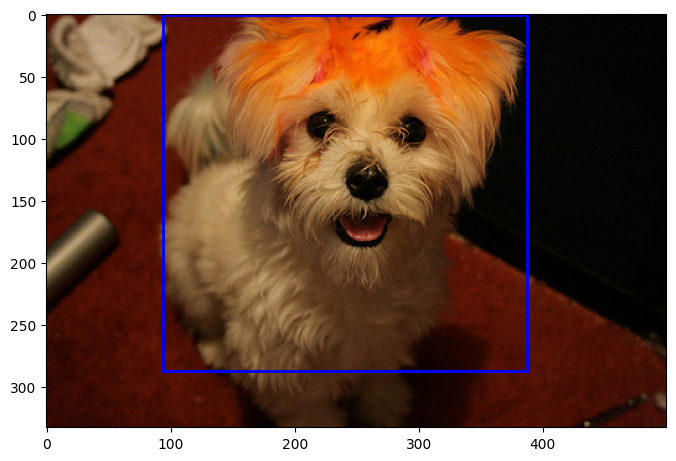

In [16]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from torchvision.transforms.functional import to_pil_image

def draw_bbox(ax, box, text, color):
  ax.add_patch(
      plt.Rectangle(
          xy=(box[0], box[1]),
          width=box[2] - box[0],
          height=box[3] - box[1],
          fill=False,
          edgecolor=color,
          linewidth=2,
      )
  )
  ax.annotate(
      text=text,
      xy=(box[0], box[1]-5),
      color=color,
      fontweight="bold",
      fontsize=13,
  )
threshold = 0.5
categories = test_dataset.categories
with torch.no_grad():
  model.eval()
  for i, (images, targets) in enumerate(test_dataloader):
    if i == 5: break
    images = [image.to(device) for image in images]
    outputs = model(images)

    boxes = outputs[0]["boxes"].to("cpu").numpy()
    labels = outputs[0]["labels"].to("cpu").numpy()
    scores = outputs[0]["scores"].to("cpu").numpy()

    boxes = boxes[scores >= threshold].astype(np.int32)
    labels = labels[scores >= threshold]
    scores = scores[scores >= threshold]

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1,1,1)
    plt.imshow(to_pil_image(images[0]))

    for box, label, score in zip(boxes, labels, scores):
      draw_bbox(ax, box, f"{categories[label]} = {score:.4f}", "red")

    tboxes = targets[0]["boxes"].numpy()
    tlabels = targets[0]["labels"].numpy()
    for box, label in zip(tboxes, tlabels):
      draw_bbox(ax, box, f"{categories[label]}", "blue")

    plt.show()

In [17]:
import numpy as np
from pycocotools.cocoeval import COCOeval

with torch.no_grad():
  model.eval()
  coco_detections = []
  for images, targets in test_dataloader:
    images = [img.to(device) for img in images]
    outputs = model(images)

    for i in range(len(targets)):
      image_id = targets[i]["image_id"].data.cpu().numpy().tolist()[0]
      boxes = outputs[i]["boxes"].data.cpu().numpy()
      boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
      boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
      scores = outputs[i]["scores"].data.cpu().numpy()
      labels = outputs[i]["labels"].data.cpu().numpy()

      for instance_id in range(len(boxes)):
        box = boxes[instance_id, :].tolist()
        prediction = np.array(
            [
                image_id,
                box[0],
                box[1],
                box[2],
                box[3],
                float(scores[instance_id]),
                int(labels[instance_id])
            ]
        )
        coco_detections.append(prediction)

  coco_detections = np.array(coco_detections)
  coco_gt = test_dataloader.dataset.coco
  coco_dt = coco_gt.loadRes(coco_detections)
  coco_evaluator = COCOeval(coco_gt, coco_dt, iouType="bbox")
  coco_evaluator.evaluate()
  coco_evaluator.accumulate()
  coco_evaluator.summarize()

Loading and preparing results...
Converting ndarray to lists...
(1595, 7)
0/1595
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.568
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.164
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.035
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.272
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.229
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.421
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.428
 Average Recall     

In [18]:
save_path = "faster_rcnn_vgg16.pth"
torch.save(model.state_dict(), save_path)
print(f"모델이 {save_path}에 저장되었습니다.")

모델이 faster_rcnn_vgg16.pth에 저장되었습니다.
